In [1]:
import sys
import os
import wandb
import torch
import numpy as np
import json

import pandas as pd
import matplotlib.pyplot as plt
from ml_collections import ConfigDict
from scipy.stats import entropy

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from Base.lla import dgala
from Base.utilities import *

from elliptic2d_files.train_elliptic2d import train_elliptic2d,generate_data,samples_param
from elliptic2d_files.elliptic2d import Elliptic2D
#from elliptic2d_files.elliptic_mcmc import *
from elliptic2d_files.utilities import *
from elliptic2d_files.physics_informed_gp2d import EllipticPIGP
from elliptic2d_files.FEM2d_Solver import Elliptic2D_FEM,Parametric_K
from scipy.interpolate import griddata, interp2d


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Elliptic 2D

$$-\nabla \cdot (a(x,\theta)\nabla u(x,\theta)) = 4x_{1}x_{2}, \quad x\in (0,1)^{2},\theta \in [-1,1]^{N}$$
$$u(x) = 0 \quad x \in \partial D$$

where $a(x,\theta)$ has the following form:
 
$$  
a(x,\theta) = \mu_{a}  +  \sum_{i,j=1}^{k_{i}, k_{j}} \sqrt a_{i,j} \theta_{i,j} b_{i,j}(x)  
$$

where $a_{n} = \frac{1}{4}\exp(- \pi (i^{2}+ j^{2})l^{2})$ and $b_{i,j} = 2 \cos(i \pi x_{1})\cos(j \pi x_{2})$.

In [2]:

def error_norm_mean(surrogate, fine_model,observation_locations,samples, device, solver = True, gp=False):
    total_error = 0
    for theta in samples:

        if solver:
            fine_model.theta = theta.cpu().numpy()  # Convert to numpy for FEM solver
            fine_model.solve()
            surg = fine_model.evaluate_at_points(observation_locations.cpu().numpy()).reshape(-1, 1)
            fine_pred = torch.tensor(surg, device=device)
        else:
            fine_pred = fine_model.prediction(theta.reshape(1,-1),var=False)


        if gp and solver:
            surrogate_pred = surrogate.prediction(theta.reshape(1,-1),var=False)
            
        else:
            data = torch.cat([observation_locations, theta.repeat(observation_locations.size(0), 1)], dim=1).float()
            surrogate_pred = surrogate.u(data.float()).detach()

        
        error = (torch.linalg.norm((fine_pred.reshape(-1,1)-surrogate_pred.reshape(-1,1)),ord=2)**2).item()
        total_error += error

    return np.sqrt(total_error / samples.shape[0])

def error_norm_marginal(surrogate, fine_model,observation_locations,samples, device, gp=False):
    total_error = 0
    for theta in samples:
    
        fine_model.theta = theta.cpu().numpy()  # Convert to numpy for FEM solver
        fine_model.solve()
        surg = fine_model.evaluate_at_points(observation_locations.cpu().numpy()).reshape(-1, 1)
        fine_pred = torch.tensor(surg, device=device)

        if gp:
            mean_surg, var_surg = surrogate.prediction(theta.reshape(1,-1),var=True)
            var_surg = torch.diag(var_surg)
            # diff = (fine_pred.reshape(-1, 1) - mean_surg.reshape(-1, 1))
            # k_inv_g = torch.linalg.solve(var_surg,diff) 
            # error = torch.matmul(diff.T, k_inv_g)

        else:
            data = torch.cat([observation_locations, theta.repeat(observation_locations.size(0), 1)], dim=1).float()
            mean_surg, var_surg = surrogate(data.float())
            mean_surg = mean_surg.view(-1, 1).detach()
            var_surg = var_surg[:, :, 0].view(-1, 1).detach()
            # error = torch.sum(((fine_pred.reshape(-1, 1) - surg_mu.reshape(-1, 1)) ** 2) / surg_sigma)
        
        error_mean = torch.linalg.norm((fine_pred.reshape(-1,1)-mean_surg.reshape(-1,1)),ord=2)**2
        error_var = torch.sum(var_surg)
        error = torch.sqrt(error_mean + error_var)
        #error = torch.sqrt(error_mean)
        total_error += error.item()

    return total_error / samples.shape[0]

In [6]:
# Example data
bins = 80
NN_config = [150,250,250]
GP_config = [150,250,250]
KLs = [2,4,5]

nn_results = {}
dgala_results = {}

gp_results = {}
gp_marginal_results = {}

for gp_config,kl in zip(GP_config,KLs):
    nn_results[f"kl_{kl}"]={}
    gp_results[f"kl_{kl}"]={}

    eval = samples_param(100,kl)


    if kl >2:
        model_specific = f"_hl3_nn250_s10000_bs800_kl{kl}"
    else:
        model_specific = f"_hl3_nn150_s1000_bs250_kl{kl}"


    path_nn_model = f"./models/elliptic2d"+model_specific+".pth"

    nn_surrogate_model = torch.load(path_nn_model)
    nn_surrogate_model.eval()

    # llp = torch.load(path_dgala_model, map_location=device)
    # llp.model.set_last_layer("output_layer")  # Re-register hooks
    # llp._device = device

    data_training,obs_points,_ = pigp_training_data_generation(gp_config,6,kl,1e-4,device)
    obs_points = torch.tensor(obs_points)

    # elliptic_gp = EllipticPIGP(data_training,device=device)
    # elliptic_gp.train_gp()
    # elliptic_gp.optimize_mll()
    # torch.save(elliptic_gp, f"./models/elliptic2d_pigp__spatial6_nsol{gp_config}_kl{kl}.pt.pt")
    
    elliptic_gp = torch.load(f"./models/elliptic2d_pigp__spatial6_nsol{gp_config}_kl{kl}.pt")

    # nn_post_eval = stat_ar(nn_post_eval, every=5000)[-1]
    # gp_post_eval = stat_ar(gp_post_eval, every=5000)[-1]

    times_nn,times_gp = [], []
    for evl in eval:
        theta = torch.tensor(evl).reshape(1,-1)

        data = torch.cat([obs_points, theta.repeat(obs_points.size(0), 1)], dim=1).float()
        
        train_timer = Timer(use_gpu=True)
        train_timer.start()
        surg = nn_surrogate_model.u(data)
        ttrain = train_timer.stop()
        times_nn.append(ttrain)

        train_timer = Timer(use_gpu=True)
        train_timer.start()
        mean = elliptic_gp.prediction(theta,var=False)
        ttrain = train_timer.stop()
        times_gp.append(ttrain)


    nn_results[f"kl_{kl}"]["eval_time"] = (np.mean(times_nn),np.std(times_nn))
    gp_results[f"kl_{kl}"]["eval_time"] = (np.mean(times_gp),np.std(times_gp))

    # samples_th = torch.normal(mean=0, std=1, size=(10000,kl))

    
    # fem_solver = Elliptic2D_FEM(np.zeros(kl), ncells=50)
    # error_mcmc = error_norm_mean(nn_surrogate_model, fem_solver,obs_points ,samples_th, device)
    # nn_results[f"kl_{kl}"]["m0_error"] = error_mcmc

    # error_mcmc = error_norm_mean(elliptic_gp, fem_solver,obs_points ,samples_th, device, gp=True)
    # gp_results[f"kl_{kl}"]["m0_error"] = error_mcmc

    nn_ind_res = {"post":[],"m_error":[]}
    gp_ind_res = {"post":[],"m_error":[]}

    for i in range(4):
        chain_fem = np.load(f'./results/e2dFEM_kl{kl}_var0.0001_{i}.npy')

        fem_solver = Elliptic2D_FEM(np.zeros(kl), ncells=50)
        error_mcmc = error_norm_mean(nn_surrogate_model, fem_solver,obs_points ,torch.tensor(chain_fem)[-10000:,:], device)
        nn_ind_res["m_error"].append(error_mcmc)

        error_mcmc = error_norm_mean(elliptic_gp, fem_solver,obs_points ,torch.tensor(chain_fem)[-10000:,:], device, gp=True)
        gp_ind_res["m_error"].append(error_mcmc)

        chain_nn = np.load(f'./results/NN'+model_specific+f'_var0.0001_{i}.npy')
        nn_post_eval = np.load(f"./results/mcmc_da_nn"+model_specific+f"_0.0001_{i}.npy")

        chain_gp = np.load(f"./results/PIGP2D_mean_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")
        gp_post_eval = np.load(f"./results/mcmc_da_pigp2d_mean_spatial6_nsol{gp_config}_kl{kl}_0.0001_{i}.npy")

        # w1_nn = discrete_W1(chain_nn,chain_fem)
        # nn_ind_res["w1"].append(w1_nn)
        
        # w1_gp = discrete_W1(chain_gp,chain_nn)
        # gp_ind_res["w1"].append(w1_gp)

        nn_ind_res["post"].append(nn_post_eval.sum()/nn_post_eval.shape[-1])
        gp_ind_res["post"].append(gp_post_eval.sum()/gp_post_eval.shape[-1])

        # solver_val = np.load(f"./results/mcmc_da_pigp2d_mean_lh_solver_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")
        # surrogate_val = np.load(f"./results/mcmc_da_pigp2d_mean_lh_nn_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")

        # dif = np.linalg.norm(solver_val - surrogate_val, ord=2, axis=1)
        # mean_dif = dif.mean()
        # gp_ind_res["bound"].append(mean_dif)

        # solver_val = np.load(f"./results/mcmc_da_nn_lh_solver"+ model_specific+ f"_var0.0001_{i}.npy")
        # surrogate_val = np.load(f"./results/mcmc_da_nn_lh_nn"+ model_specific+ f"_var0.0001_{i}.npy")

        # dif = np.linalg.norm(solver_val - surrogate_val, ord=2, axis=1)
        # mean_dif = dif.mean()
        # nn_ind_res["bound"].append(mean_dif)


    # nn_mean, nn_std = (np.mean(nn_ind_res["w1"]),np.std(nn_ind_res["w1"]))
    # gp_mean, gp_std = (np.mean(gp_ind_res["w1"]),np.std(gp_ind_res["w1"]))

    # nn_results[f"kl_{kl}"]["w1"] = (nn_mean, nn_std)

    # gp_results[f"kl_{kl}"]["w1"] = (gp_mean, gp_std)
    
    nn_mean, nn_std = (np.mean(nn_ind_res["post"]),np.std(nn_ind_res["post"]))
    gp_mean, gp_std = (np.mean(gp_ind_res["post"]), np.std(gp_ind_res["post"]))

    nn_results[f"kl_{kl}"]["post_eval"] = (nn_mean, nn_std)

    gp_results[f"kl_{kl}"]["post_eval"] = (gp_mean, gp_std)

        
    nn_mean, nn_std = (np.mean(nn_ind_res["m_error"]),np.std(nn_ind_res["m_error"]))
    gp_mean, gp_std = (np.mean(gp_ind_res["m_error"]), np.std(gp_ind_res["m_error"]))

    nn_results[f"kl_{kl}"]["m_error"] = (nn_mean, nn_std)

    gp_results[f"kl_{kl}"]["m_error"] = (gp_mean, gp_std)

    # error_mcmc = error_norm_mean(nn_surrogate_model, elliptic_gp,obs_points ,torch.tensor(chain_fem)[-10000:,:], device,solver=False, gp=False)
    # gp_results[f"kl_{kl}"]["nn_gp"] = error_mcmc

In [4]:
nn_results

{'kl_3': {'eval_time': (0.00028026077954564245, 8.601089844769165e-05),
  'post_eval': (0.9507525, 0.0007823482280928505),
  'm_error': (0.01623253552665309, 0.0004658911357450943)}}

In [5]:
gp_results

{'kl_3': {'eval_time': (0.00019779570051468907, 6.0534956426305864e-05),
  'post_eval': (0.963585, 0.00014874474780642626),
  'm_error': (0.016160001214990935, 0.00046609681235545216)}}

In [7]:
nn_results

{'kl_2': {'eval_time': (0.00020785146858543158, 9.10940428878527e-05),
  'post_eval': (0.9768749999999999, 0.00016039014932343917),
  'm_error': (0.0002486916456811029, 6.240641383841878e-07)},
 'kl_4': {'eval_time': (0.00026986017823219297, 2.781518267157204e-05),
  'post_eval': (0.9569225, 0.0009885437521930894),
  'm_error': (0.016513059972984315, 0.00035166209177729413)},
 'kl_5': {'eval_time': (0.00034455887973308566, 6.254572337222293e-05),
  'post_eval': (0.8853325000000001, 0.0010157601833110242),
  'm_error': (0.0017908426987134516, 1.9390392155007488e-05)}}

In [8]:
gp_results

{'kl_2': {'eval_time': (0.00017242803820408881, 7.52718993537091e-05),
  'post_eval': (0.97089, 0.0002263846284534436),
  'm_error': (0.00031082370988116075, 1.971284765297102e-06)},
 'kl_4': {'eval_time': (0.00018394070124486462, 1.62598862087338e-05),
  'post_eval': (0.9460250000000001, 0.0004129467277991116),
  'm_error': (0.01643928863278434, 0.00035035949281557574)},
 'kl_5': {'eval_time': (0.000235948090266902, 3.883925842792602e-05),
  'post_eval': (0.9427099999999999, 0.0013153896761036326),
  'm_error': (0.0008638269841449338, 1.4639412859145156e-05)}}

# Marginal

In [ ]:
# Example data
bins = 80
NN_config = [150,250,250]
GP_config = [150,250,250]
KLs = [2,3,4,5]

dgala_results = {}
gp_marginal_results = {}

for gp_config,kl in zip(GP_config,KLs):
    dgala_results[f"kl_{kl}"]={}
    gp_marginal_results[f"kl_{kl}"]={}

    eval = samples_param(100,kl)


    if kl >2:
        model_specific = f"_hl3_nn250_s10000_bs800_kl{kl}"
    else:
        model_specific = f"_hl3_nn150_s1000_bs250_kl{kl}"


    path_nn_model = f"./models/elliptic2d_dgala"+model_specific+".pth"

    llp = torch.load(path_nn_model)
    llp.model.set_last_layer("output_layer")  # Re-register hooks
    llp._device = device


    # llp = torch.load(path_dgala_model, map_location=device)
    # llp.model.set_last_layer("output_layer")  # Re-register hooks
    # llp._device = device

    data_training,obs_points,_ = pigp_training_data_generation(gp_config,6,kl,1e-4,device)
    obs_points = torch.tensor(obs_points)

    # elliptic_gp = EllipticPIGP(data_traimning,device=device)
    # elliptic_gp.train_gp()
    # elliptic_gp.optimize_mll()
    # torch.save(elliptic_gp, f"./models/elliptic2d_pigp__spatial6_nsol{gp_config}_kl{kl}.pt.pt")
    
    elliptic_gp = torch.load(f"./models/elliptic2d_pigp__spatial6_nsol{gp_config}_kl{kl}.pt")

    # nn_post_eval = stat_ar(nn_post_eval, every=5000)[-1]
    # gp_post_eval = stat_ar(gp_post_eval, every=5000)[-1]

    times_nn,times_gp = [], []
    for evl in eval:
        theta = torch.tensor(evl).reshape(1,-1)

        data = torch.cat([obs_points, theta.repeat(obs_points.size(0), 1)], dim=1).float()
        
        train_timer = Timer(use_gpu=True)
        train_timer.start()
        surg = llp(data)
        ttrain = train_timer.stop()
        times_nn.append(ttrain)

        train_timer = Timer(use_gpu=True)
        train_timer.start()
        mean = elliptic_gp.prediction(theta,var=True)
        ttrain = train_timer.stop()
        times_gp.append(ttrain)


    dgala_results[f"kl_{kl}"]["eval_time"] = (np.mean(times_nn),np.std(times_nn))
    gp_marginal_results[f"kl_{kl}"]["eval_time"] = (np.mean(times_gp),np.std(times_gp))

    # samples_th = torch.normal(mean=0, std=1, size=(10000,kl))

    
    # fem_solver = Elliptic2D_FEM(np.zeros(kl), ncells=50)
    # error_mcmc = error_norm_mean(nn_surrogate_model, fem_solver,obs_points ,samples_th, device)
    # nn_results[f"kl_{kl}"]["m0_error"] = error_mcmc

    # error_mcmc = error_norm_mean(elliptic_gp, fem_solver,obs_points ,samples_th, device, gp=True)
    # gp_results[f"kl_{kl}"]["m0_error"] = error_mcmc

    nn_ind_res = {"post":[],"m_error":[]}
    gp_ind_res = {"post":[],"m_error":[]}

    for i in range(4):
        chain_fem = np.load(f'./results/e2dFEM_kl{kl}_var0.0001_{i}.npy')

        fem_solver = Elliptic2D_FEM(np.zeros(kl), ncells=50)
        error_mcmc = error_norm_marginal(llp, fem_solver,obs_points ,torch.tensor(chain_fem)[-100:,:], device)
        nn_ind_res["m_error"].append(error_mcmc)

        error_mcmc = error_norm_marginal(elliptic_gp, fem_solver,obs_points ,torch.tensor(chain_fem)[-100:,:], device, gp=True)
        gp_ind_res["m_error"].append(error_mcmc)

        chain_nn = np.load(f'./results/dgala'+model_specific+f'_var0.0001_{i}.npy')
        nn_post_eval = np.load(f"./results/mcmc_da_dgala"+model_specific+f"_0.0001_{i}.npy")

        # chain_gp = np.load(f"./results/PIGP2D_mean_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")
        # gp_post_eval = np.load(f"./results/mcmc_da_pigp2d_mean_spatial6_nsol{gp_config}_kl{kl}_0.0001_{i}.npy")

        # w1_nn = discrete_W1(chain_nn,chain_fem)
        # nn_ind_res["w1"].append(w1_nn)
        
        # w1_gp = discrete_W1(chain_gp,chain_nn)
        # gp_ind_res["w1"].append(w1_gp)

        nn_ind_res["post"].append(nn_post_eval.sum()/nn_post_eval.shape[-1])
        #gp_ind_res["post"].append(gp_post_eval.sum()/gp_post_eval.shape[-1])

        # solver_val = np.load(f"./results/mcmc_da_pigp2d_mean_lh_solver_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")
        # surrogate_val = np.load(f"./results/mcmc_da_pigp2d_mean_lh_nn_spatial6_nsol{gp_config}_kl{kl}_var0.0001_{i}.npy")

        # dif = np.linalg.norm(solver_val - surrogate_val, ord=2, axis=1)
        # mean_dif = dif.mean()
        # gp_ind_res["bound"].append(mean_dif)

        # solver_val = np.load(f"./results/mcmc_da_nn_lh_solver"+ model_specific+ f"_var0.0001_{i}.npy")
        # surrogate_val = np.load(f"./results/mcmc_da_nn_lh_nn"+ model_specific+ f"_var0.0001_{i}.npy")

        # dif = np.linalg.norm(solver_val - surrogate_val, ord=2, axis=1)
        # mean_dif = dif.mean()
        # nn_ind_res["bound"].append(mean_dif)


    # nn_mean, nn_std = (np.mean(nn_ind_res["w1"]),np.std(nn_ind_res["w1"]))
    # gp_mean, gp_std = (np.mean(gp_ind_res["w1"]),np.std(gp_ind_res["w1"]))

    # nn_results[f"kl_{kl}"]["w1"] = (nn_mean, nn_std)

    # gp_results[f"kl_{kl}"]["w1"] = (gp_mean, gp_std)
    
    nn_mean, nn_std = (np.mean(nn_ind_res["post"]),np.std(nn_ind_res["post"]))
    #gp_mean, gp_std = (np.mean(gp_ind_res["post"]), np.std(gp_ind_res["post"]))

    dgala_results[f"kl_{kl}"]["post_eval"] = (nn_mean, nn_std)

    #gp_marginal_results[f"kl_{kl}"]["post_eval"] = (gp_mean, gp_std)

        
    nn_mean, nn_std = (np.mean(nn_ind_res["m_error"]),np.std(nn_ind_res["m_error"]))
    gp_mean, gp_std = (np.mean(gp_ind_res["m_error"]), np.std(gp_ind_res["m_error"]))

    dgala_results[f"kl_{kl}"]["m_error"] = (nn_mean, nn_std)

    gp_marginal_results[f"kl_{kl}"]["m_error"] = (gp_mean, gp_std)

    # error_mcmc = error_norm_mean(nn_surrogate_model, elliptic_gp,obs_points ,torch.tensor(chain_fem)[-10000:,:], device,solver=False, gp=False)
    # gp_results[f"kl_{kl}"]["nn_gp"] = error_mcmc

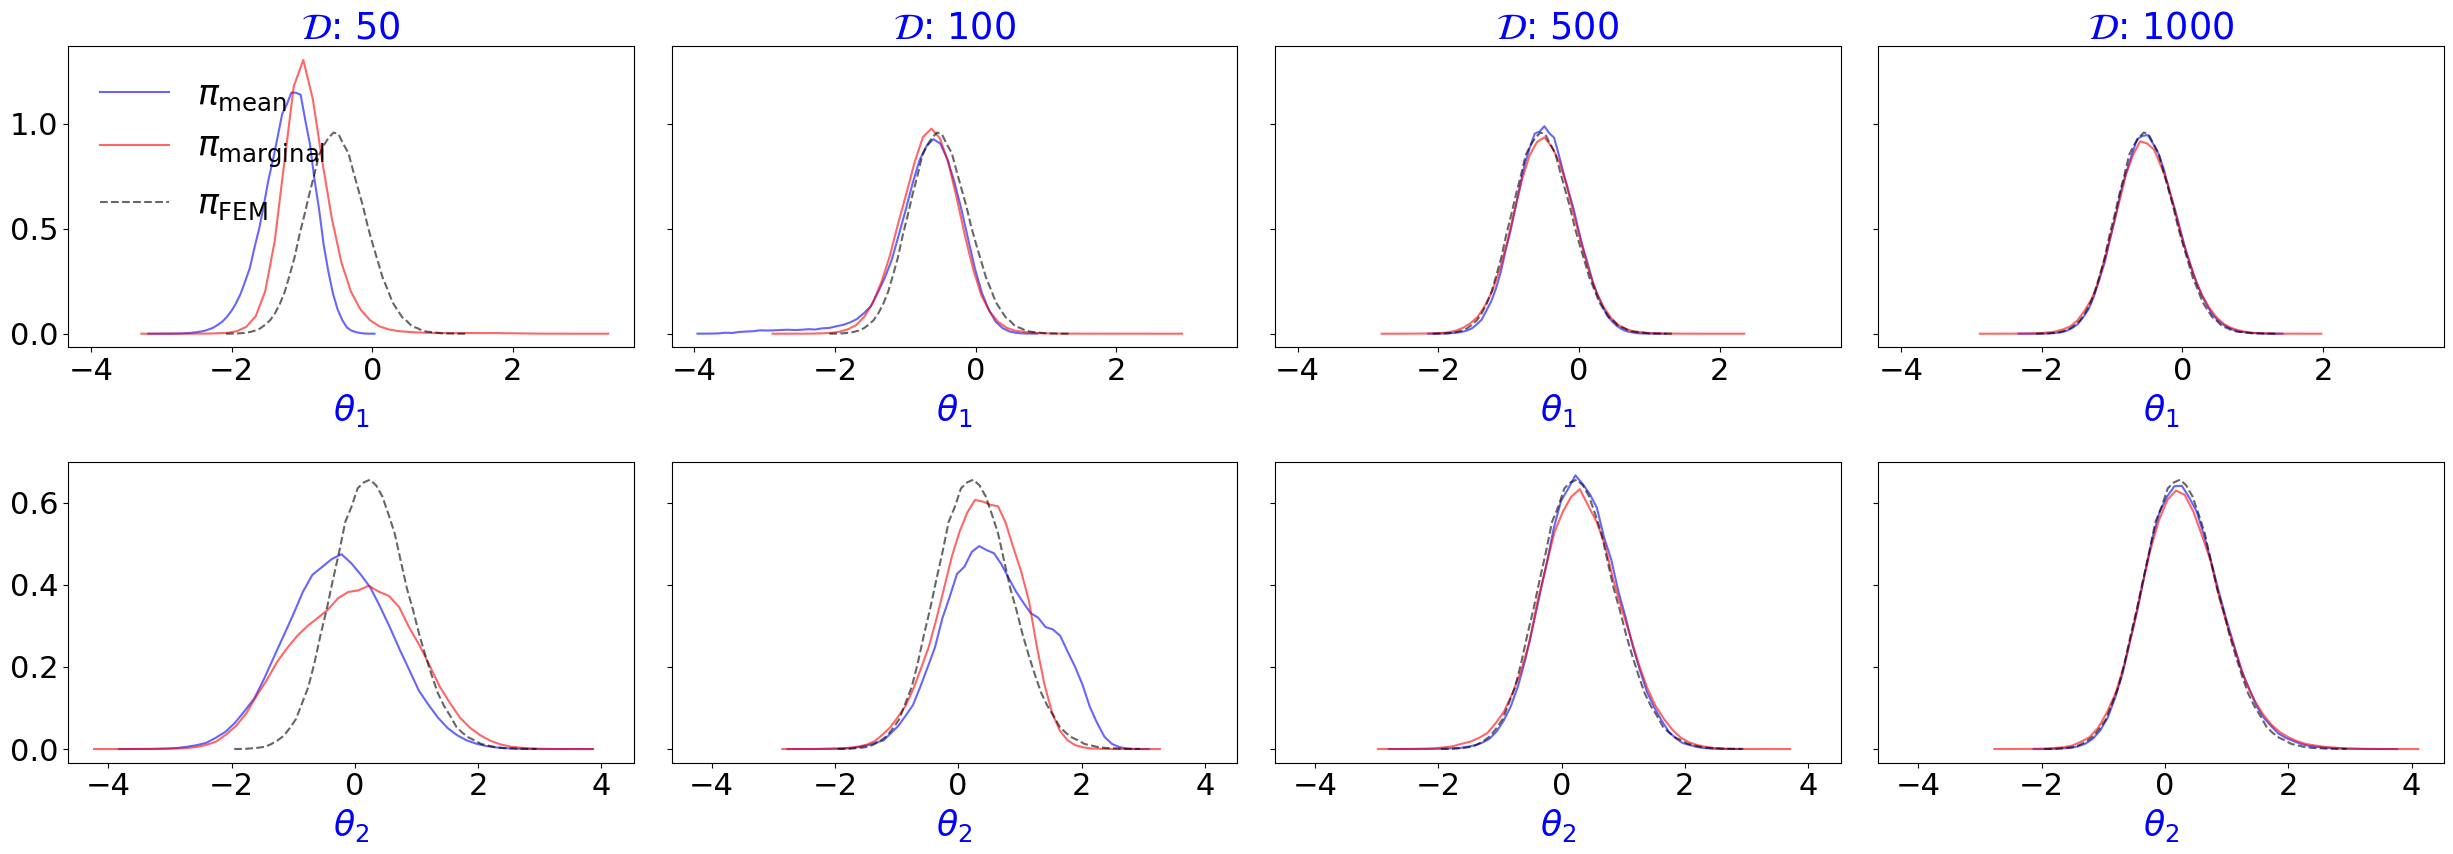

In [20]:
vr = 1e-4
theta_th = np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])
#N = [100, 250, 500, 1000, 1500, 2500, 4000, 5000]
N = [50,100,500,1000]
bins = 50
kl = 2
nn = 150

fig, axs = plt.subplots(2,len(N), figsize=(25, 9), sharey="row", sharex="row")
#fig.suptitle(f"Posterior Distributions")
#fig.suptitle(f"Posterior Distributions: Var  = {vr}")
plt.rcParams.update({'font.size': 22})

for i,(nobs,batch) in  enumerate(zip(N,[10,10,250,250])):

    sample = np.load(f'./results/NN_hl{3}_nn{nn}_s{nobs}_bs{batch}_kl{kl}_var{vr}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{mean}}$",color = "blue")

    sample = np.load(f'./results/dgala_hl{3}_nn{nn}_s{nobs}_bs{batch}_kl{kl}_var{vr}_0.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label =r"$\pi_{\text{marginal}}$",color = "red")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=1.5, label = r"$\pi_{\text{marginal}}$",color = "red")
    
    sample = np.load(f'./results/e2dFEM_kl{kl}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1,i].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=1.5, label = r"$\pi_{\text{FEM}}$",color = "black")
    
    axs[0,i].set_xlabel("$\\theta_{1}$",color="blue",fontsize = 25),axs[1,i].set_xlabel("$\\theta_{2}$",color="blue",fontsize = 25)
    axs[0,i].set_title(f"$\mathcal{{D}}$: {nobs}", color ="blue")
    # axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    # axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)
    # axs[0,i].set_xlim((-.5,0.8))
    # axs[1,i].set_xlim((0.2,0.55))
    axs[0,i].tick_params(axis='both', labelsize=22)
    axs[1,i].tick_params(axis='both', labelsize=22)


axs[0,0].legend(frameon = False, prop={'size': 25},loc='upper left')
# axs[0, 0].legend(
#     frameon=False,
#     prop={'size': 15},
#     loc='upper right',
#     bbox_to_anchor=(3.7, 1)  # Adjust position as needed
# )
#axs[-1,0].set_xlim((-0.3,0.6)),axs[-1,1].set_xlim((0.25,0.5))
plt.tight_layout()
plt.savefig(f"./results/images/elliptic2d_pd_kl{kl}_{vr}.pdf", bbox_inches='tight') 

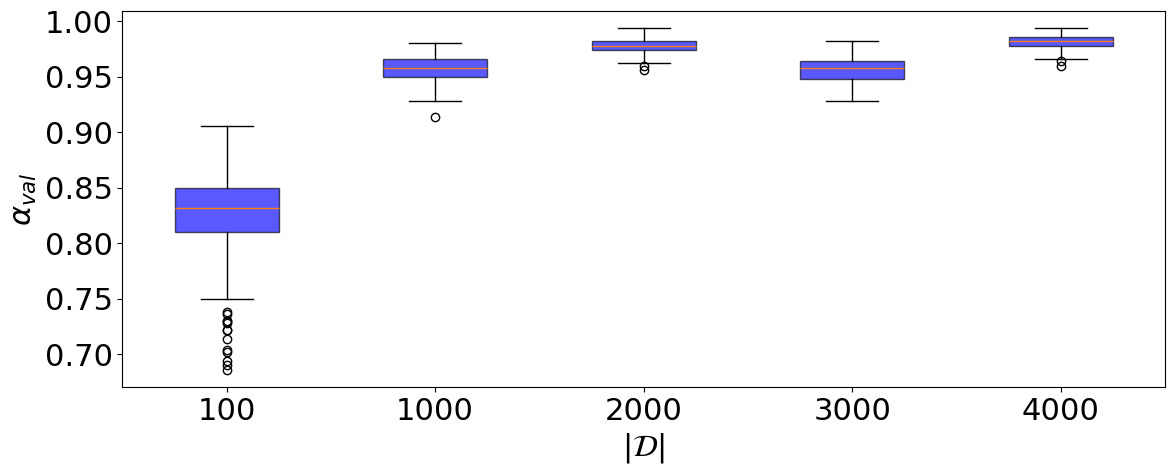

In [22]:
N = [100,1000,2000,3000,4000]

acceptance_mean_list = np.array([stat_ar(np.load(f"./results/mcmc_da_nn_hl3_nn150_s{n}_bs{250}_kl{kl}_{vr}.npy"),every=500)[-1] for n in N])
cl = ["red", "blue", "green", "orange", "black","orange","tomato"]

fig, axs = plt.subplots(1, figsize=(12, 5), sharex="col")
plt.rcParams.update({'font.size': 15})

bplot = axs.boxplot(acceptance_mean_list.T,patch_artist=True, labels=[str(n) for n in N])  # Transpose to plot along axis 1
#plt.suptitle(f"Acceptance Rate for different NN",color = "blue")
# fill with colors
for patch, color in zip(bplot['boxes'], cl):
    patch.set_facecolor("blue")
    patch.set_alpha(0.65)
    patch.set_linewidth(1)

# Customize the plot
axs.set_xlabel("$|\\mathcal{D}|$")
axs.set_ylabel("$\\alpha_{val}$")
#plt.ylim((0,0.5))
# Save the plotx
plt.savefig(f"./results/images/elliptic2d_da_ar_kl{kl}_{vr}.pdf")
axs.legend(frameon =False)
plt.tight_layout()
plt.show()

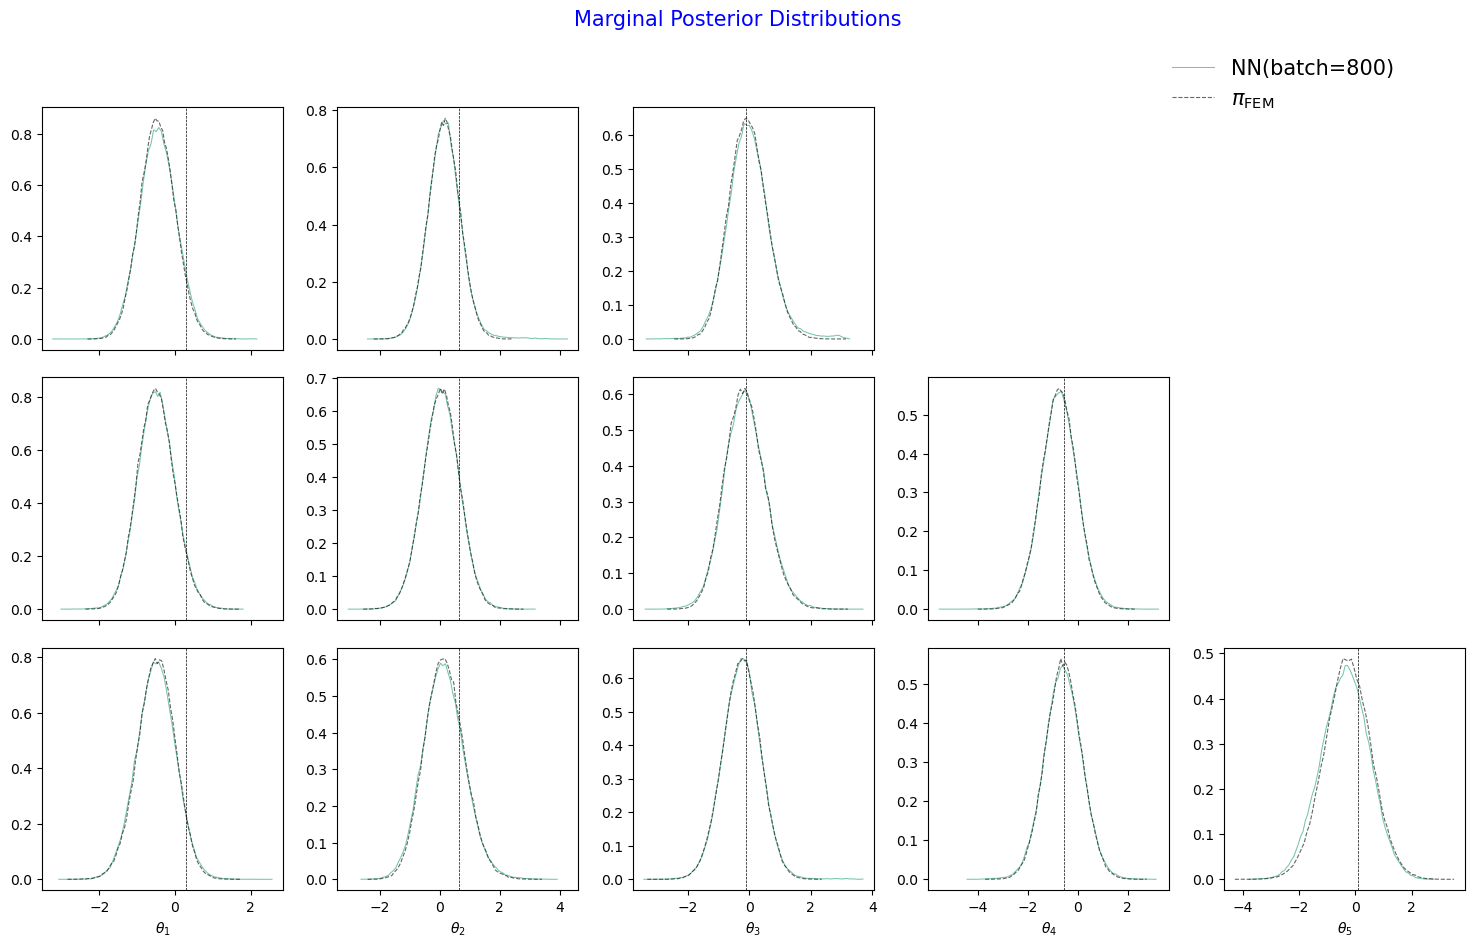

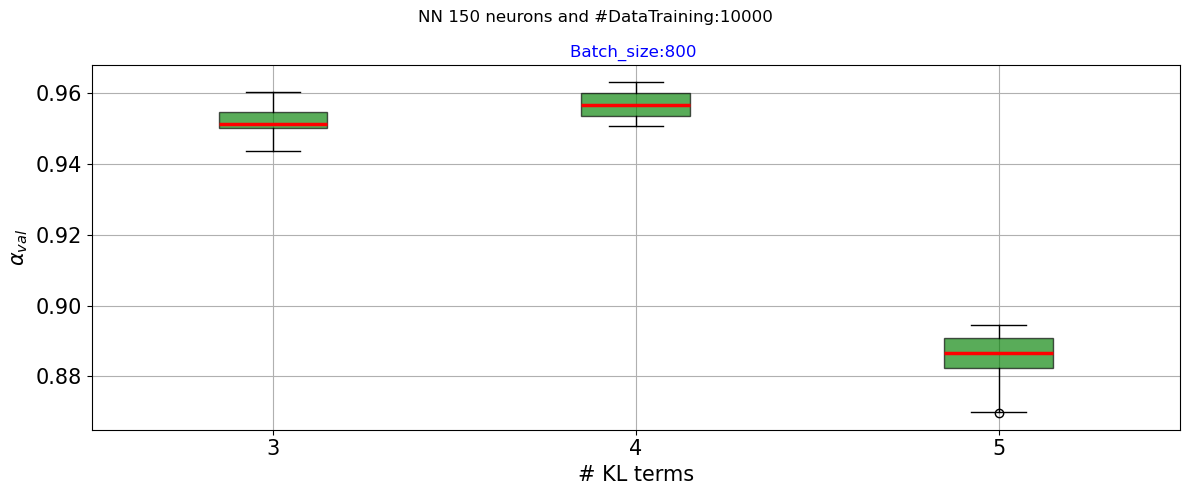

In [5]:
vr = 1e-4
_, _,theta_th = generate_noisy_obs(6, 20)

nobs = 10000  # All N you want to plot
kl = [3,4,5]
bins = 80
#100 160 200 250 400 500
batches = [800]

colors = plt.cm.Dark2(np.linspace(0, 1, len(batches)))  # Color map for different N

fig, axs = plt.subplots(len(kl), max(kl), figsize=(15, 10), sharex="col")
fig.suptitle(f"Marginal Posterior Distributions", color="blue", fontsize =15)
plt.rcParams.update({'font.size': 15})

# Ensure axs is always 2D
if len(kl) == 1:
    axs = axs[np.newaxis, :]

for i, k in enumerate(kl):  # loop over kl rows
    for z,batch in enumerate(batches):
        try:
            sample_nn = np.load(f'./results/NN_hl3_nn{250}_s{nobs}_bs{batch}_kl{k}_var{vr}_0.npy')
        except FileNotFoundError:
            print(f"Warning: file for N={nobs}, KL={k} not found.")
            continue  # skip if file is missing

        for j in range(k):  # only kl[i] subplots active
            bin_centers, counts = histogram_(sample_nn[:, j], bins=bins)
            axs[i, j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                        color=colors[z], label=f"NN(batch={batch})" if j == 0 else None)  # Label only once per N
            axs[i, j].axvline(x=theta_th[j], color='black', linestyle="--", linewidth=0.5)

            if z == 0 :

                sample = np.load(f'./results/e2dFEM_kl{k}_var{vr}.npy')

                bin_centers, counts = histogram_(sample[:, j],bins=bins)
                axs[i,j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")
        
            if i == len(kl) - 1:
                axs[i, j].set_xlabel(f"$\\theta_{j+1}$")

    # Hide unused subplots in each row
    for j in range(k, max(kl)):
        axs[i, j].axis('off')

# Add legend only once (you can also do per-plot legends if you prefer)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.95),frameon = False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(f"./results/images/elliptic2d_pd_kls_batches_var{vr}.pdf")


# For each kl, collect acceptance means across N
acceptance_mean_list = []

for kls in kl:
    tmp = []
    for batch in batches:
        data = np.load(f"./results/mcmc_da_nn_hl3_nn{250}_s{nobs}_bs{batch}_kl{kls}_{vr}_0.npy")
        stat = stat_ar(data, every=5000)[-1]
        tmp.append(stat)
    acceptance_mean_list.append(tmp)

acceptance_mean_array = np.array(acceptance_mean_list)  # shape: (len(kl), len(N))

# Now plot
fig, ax = plt.subplots(1,len(batches),figsize=(12, 5), sharex=True, sharey=True)
plt.rcParams.update({'font.size': 10})
fig.suptitle(f"NN 150 neurons and #DataTraining:{nobs}")
# Create boxplot
for i,batch in enumerate(batches):
    bplot = ax.boxplot(acceptance_mean_array[:,i].T, patch_artist=True, labels=[str(k) for k in kl])

    # Fill each box with color (one color per kl)
    for patch in bplot['boxes']:
        patch.set_facecolor("green")
        patch.set_alpha(0.65)
        patch.set_linewidth(1)

    # Customize median lines
    for median in bplot['medians']:
        median.set_color('red')     # Black medians
        median.set_linewidth(2.5)      # Thicker line

    # Labeling
    ax.set_ylabel("$\\alpha_{val}$")
    ax.set_title(f"Batch_size:{batch} ", color="blue")
    ax.grid(True)
    ax.set_xlabel("# KL terms")


plt.savefig(f"./results/images/elliptic2d_da_ar_kls_batches_{vr}.pdf", bbox_inches='tight')
plt.tight_layout()

# axs.legend(frameon =False)

# plt.show()

TypeError: 'Axes' object is not subscriptable

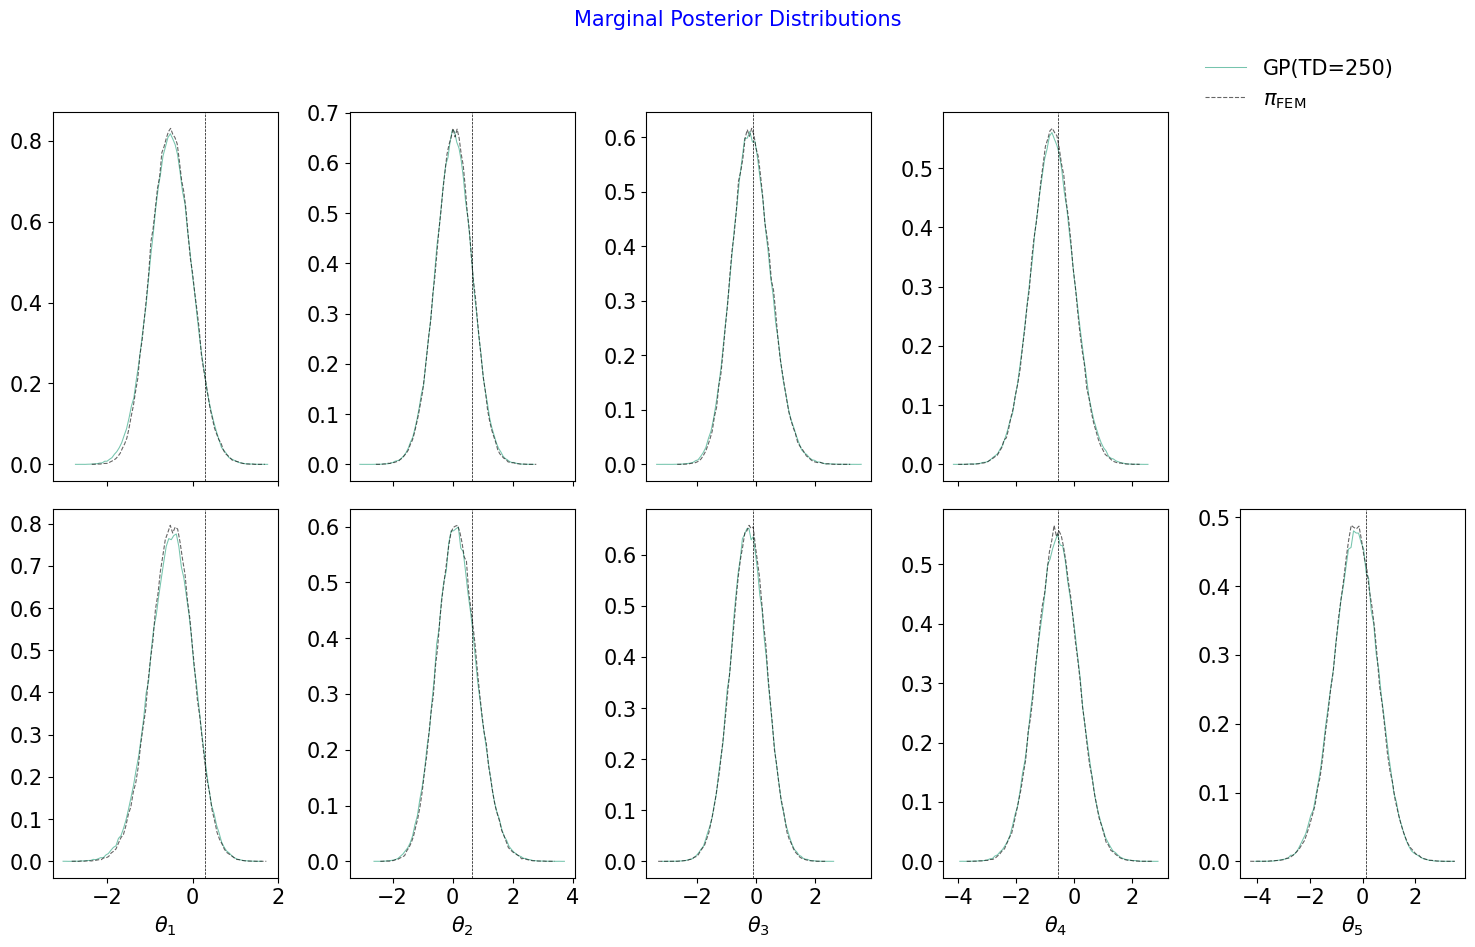

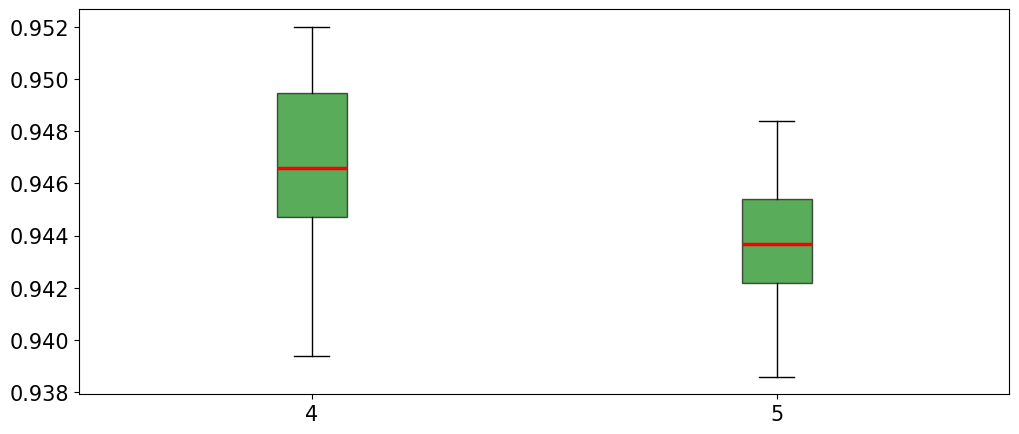

In [7]:
vr = 1e-4
_, _,theta_th = generate_noisy_obs(6, 20)

nobs = 4000  # All N you want to plot
kl = [4,5]
bins = 80
#100 160 200 250 400 500
batches = [250]

colors = plt.cm.Dark2(np.linspace(0, 1, len(batches)))  # Color map for different N

fig, axs = plt.subplots(len(kl), max(kl), figsize=(15, 10), sharex="col")
fig.suptitle(f"Marginal Posterior Distributions", color="blue", fontsize =15)
plt.rcParams.update({'font.size': 15})

# Ensure axs is always 2D
if len(kl) == 1:
    axs = axs[np.newaxis, :]

for i, k in enumerate(kl):  # loop over kl rows
    for z,batch in enumerate(batches):
        try:
            sample_nn = np.load(f'./results/PIGP2D_mean_spatial6_nsol{batch}_kl{k}_var{vr}_0.npy')
        except FileNotFoundError:
            print(f"Warning: file for N={nobs}, KL={k} not found.")
            continue  # skip if file is missing

        for j in range(k):  # only kl[i] subplots active
            bin_centers, counts = histogram_(sample_nn[:, j], bins=bins)
            axs[i, j].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75,
                        color=colors[z], label=f"GP(TD={batch})" if j == 0 else None)  # Label only once per N
            axs[i, j].axvline(x=theta_th[j], color='black', linestyle="--", linewidth=0.5)

            if z == 0 :

                sample = np.load(f'./results/e2dFEM_kl{k}_var{vr}.npy')

                bin_centers, counts = histogram_(sample[:, j],bins=bins)
                axs[i,j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.8, label = r"$\pi_{\text{FEM}}$",color = "black")
        
            if i == len(kl) - 1:
                axs[i, j].set_xlabel(f"$\\theta_{j+1}$")

    # Hide unused subplots in each row
    for j in range(k, max(kl)):
        axs[i, j].axis('off')

# Add legend only once (you can also do per-plot legends if you prefer)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.95),frameon = False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(f"./results/images/elliptic2d_pigp2d_pd_kls_samples{batches}_var{vr}.pdf")


# For each kl, collect acceptance means across N
acceptance_mean_list = []

for kls in kl:
    tmp = []
    for batch in batches:
        data = np.load(f"./results/mcmc_da_pigp2d_mean_spatial6_nsol{batch}_kl{kls}_{vr}_0.npy")
        stat = stat_ar(data, every=5000)[-1]

        tmp.append(stat)
    acceptance_mean_list.append(tmp)

acceptance_mean_array = np.array(acceptance_mean_list)  # shape: (len(kl), len(N))

# Now plot
fig, ax = plt.subplots(1,len(batches),figsize=(12, 5), sharex=True, sharey=True)
plt.rcParams.update({'font.size': 10})
#fig.suptitle("NN 100 neurons and #DataTraining:4,000")
# Create boxplot
for i,batch in enumerate(batches):
    bplot = ax.boxplot(acceptance_mean_array[:,i].T, patch_artist=True, labels=[str(k) for k in kl])

    # Fill each box with color (one color per kl)
    for patch in bplot['boxes']:
        patch.set_facecolor("green")
        patch.set_alpha(0.65)
        patch.set_linewidth(1)

    # Customize median lines
    for median in bplot['medians']:
        median.set_color('red')     # Black medians
        median.set_linewidth(2.5)      # Thicker line

    # Labeling
    ax[i].set_ylabel("$\\alpha_{val}$")
    ax[i].set_title(f"NTraining_Data:{batch} ", color="blue")
    ax[i].grid(True)
    ax[i].set_xlabel("# KL terms")
    ax[i].set_ylim(0.5,1)


plt.savefig(f"./results/images/elliptic2d_pigp2d_da_ar_kls_samples{batches}_{vr}.pdf", bbox_inches='tight')
plt.tight_layout()

# axs.legend(frameon =False)
# plt.show()

In [58]:
data = np.load(f"./results/mcmc_da_pigp2d_mean_spatial6_nsol{250}_kl{5}_{vr}.npy")
stat = stat_ar(data, every=5000)[-1]
stat.mean()

0.9434899

In [20]:
model_specific = f"_hl{3}_nn{250}_s{10000}_bs{800}_kl{4}"
path_nn_model = f"./models/elliptic2d"+model_specific+".pth"
path_dgala_model = f"./models/elliptic2d_dgala"+model_specific+".pth"
path_nn_model = f"./models/elliptic2d"+model_specific+".pth"

nn_surrogate_model = torch.load(path_nn_model)
nn_surrogate_model.eval()

data_fit = deepgala_data_fit(1000,4,device)

# llp = dgala(nn_surrogate_model)
# llp.fit(data_fit)
# llp.optimize_marginal_likelihood()

# llp = torch.load(path_dgala_model, map_location=device)
# llp.model.set_last_layer("output_layer")  # Re-register hooks
# llp._device = device


In [169]:
torch.linalg.eigvals(llp.H)

tensor([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 

In [111]:
import torch
from torch.nn.utils import parameters_to_vector
from torch.distributions.multivariate_normal import _precision_to_scale_tril

from  Base.utilities import get_decorated_methods
from Base.utilities import FeatureExtractor

from copy import deepcopy
from math import sqrt, pi

class dgala(torch.nn.Module):
    def __init__(self, dga, sigma_noise=1., prior_precision=1.,prior_mean=0., last_layer_name = "output_layer"):
        super(dgala, self).__init__()

        self.dgala = deepcopy(dga)
        self.model = FeatureExtractor(deepcopy(dga.model), last_layer_name = last_layer_name)
        self._device = next(dga.model.parameters()).device
        self.lossfunc = torch.nn.MSELoss(reduction ='mean')
        
        self.loss = 0
        self.temperature = 1
        self.H = None
        self.mean = None
        self.n_params = None
        self.n_data = {key: None for key in self.dgala.lambdas.keys()}

        self._prior_precision = torch.tensor([prior_precision], device=self._device)
        self._prior_mean = torch.tensor([prior_mean], device=self._device)
        self._sigma_noise = torch.tensor(sigma_noise,device=self._device).float()

        if hasattr(self.dgala, "chunks"):
            self.chunks = self.dgala.chunks
            self.gamma = self.dgala.gamma.clone()
        else:
            self.chunks = None

    @property
    def prior_precision(self):
        return self._prior_precision
    
    @prior_precision.setter
    def prior_precision(self, new_prior_precision):
        if isinstance(new_prior_precision, torch.Tensor):
            self._prior_precision = new_prior_precision.to(self._device)
        else:
            self._prior_precision = torch.tensor([new_prior_precision], device=self._device).float()

    @property
    def sigma_noise(self):
        return self._sigma_noise

    @sigma_noise.setter
    def sigma_noise(self, new_sigma_noise):
        if isinstance(new_sigma_noise, torch.Tensor):
            self._sigma_noise = new_sigma_noise.to(self._device)
        else:
            self._sigma_noise = torch.tensor(new_sigma_noise, device=self._device,requires_grad=True).float()

    @property
    def posterior_precision(self):
        """Diagonal posterior precision \\(p\\)."""
        return self._H_factor * self.H + torch.diag(self.prior_precision_diag)

    @property
    def posterior_covariance(self):
        """Diagonal posterior variance \\(p^{-1}\\).""" 
        post_scale = _precision_to_scale_tril(self.posterior_precision)
        return post_scale @ post_scale.T

    @property
    def _H_factor(self):
        sigma2 = self.sigma_noise.square()
        return 1 / sigma2 / self.temperature
    
    @property
    def prior_precision_diag(self):
        """Obtain the diagonal prior precision \\(p_0\\) constructed from either
        a scalar, layer-wise, or diagonal prior precision."""

        if len(self.prior_precision) == 1:  # scalar
            return self.prior_precision * torch.ones(self.n_params, device=self._device)

        elif len(self.prior_precision) == self.n_params:  # diagonal
            return self.prior_precision
        
    @property
    def scatter(self):
        """Computes the _scatter_, a term of the log marginal likelihood that
        corresponds to L-2 regularization:
        `scatter` = \\((\\theta_{MAP} - \\mu_0)^{T} P_0 (\\theta_{MAP} - \\mu_0) \\)."""

        delta = (self.mean - self.prior_mean)
        return (delta * self.prior_precision_diag) @ delta

    @property
    def log_det_prior_precision(self):
        """Compute log determinant of the prior precision
        \\(\\log \\det P_0\\)"""

        return self.prior_precision_diag.log().sum()

    @property
    def log_det_posterior_precision(self):
        """Compute log determinant of the posterior precision
        \\(\\log \\det P\\) which depends on the subclasses structure
        used for the Hessian approximation."""
        return self.posterior_precision.logdet()

    @property
    def log_det_ratio(self):
        """Compute the log determinant ratio, a part of the log marginal likelihood.
        \\[
            \\log \\frac{\\det P}{\\det P_0} = \\log \\det P - \\log \\det P_0
        \\]log"""
        return self.log_det_posterior_precision - self.log_det_prior_precision
    
    @property
    def log_likelihood(self):
        """Compute log likelihood on the training data after `.fit()` has been called.
        The log likelihood is computed on-demand based on the loss and, for example,
        the observation noise, which makes it differentiable in the latter for
        iterative updates."""

        factor = -self._H_factor
        total_log_likelihood = 0.0

        for key, loss_value in self.loss.items():
            # Compute the normalizer term for Gaussian likelihood
            n_data_key = self.n_data[key]  # Number of data points for this key
            normalizer = n_data_key * torch.log(self.sigma_noise*sqrt(2*pi))

            # Compute log likelihood contribution for this key
            log_likelihood_key = factor *n_data_key* loss_value - normalizer

            # Accumulate total log likelihood
            total_log_likelihood += log_likelihood_key

        return total_log_likelihood
    

    def fit(self,fit_data):
        """Fit the local Laplace approximation at the parameters of the model."""
        
        self.class_methods = get_decorated_methods(self.dgala, decorator = "use_laplace")

       # assert set(self.class_methods) == set([element for sublist in fit_data["class_method"].values() for element in sublist])

        self.dgala.model.eval()
        #self.mean = parameters_to_vector(self.dgala.model.output_layer.parameters()).detach()
        self.mean = parameters_to_vector(self.model.last_layer.parameters()).detach()
        self.n_params = len(self.mean)
        self.prior_mean = self._prior_mean
        self._init_H()

        # Dynamically pass the `data_fit` contents as *args
        data_fit_args = fit_data.get("data_fit", {})
        unpacked_args = []
        for key, value in data_fit_args.items():
            if isinstance(value, tuple):
                # Unpack the tuple and add its elements individually
                unpacked_args.extend(value)
            else:
                # Add non-tuple values directly
                unpacked_args.append(value)

        loss = self.dgala.losses(*unpacked_args,loss_fn = self.lossfunc)

        self.loss = {key:loss.item() for key,loss in loss.items()}

        #self.full_Hessian(fit_data)
        
    def _init_H(self):
        self.H = torch.zeros(self.n_params,self.n_params,device=self._device)

    def gradient_outograd(self, y, x):
        grad_p = torch.autograd.grad(outputs=y, 
                                 inputs=x, create_graph=True, allow_unused=True, materialize_grads=True)
        return [grp.detach() for grp in grad_p]
    
    def full_Hessian(self,fit_data):
        parameters_ = list(self.dgala.model.output_layer.parameters())
        damping = torch.eye(self.n_params,device=self._device)*1e-10

        for key,dt_fit in fit_data["data_fit"].items():
            dt_fit = dt_fit[1] if isinstance(dt_fit, tuple) else dt_fit

            for z,clm in enumerate(fit_data["class_method"][key]):
                self.dgala.model.zero_grad()
                fout = getattr(self.dgala, clm)(dt_fit)

                if isinstance(fout, tuple):  # Check if fout is a tuple
                    for i, f_out_indv in enumerate(fout):  # Iterate over fout if it's a tuple
                        indv_h = self.compute_hessian(f_out_indv,parameters_,key)
                        self. H += (indv_h + damping)*self.dgala.lambdas[fit_data["outputs"][key][i]]
                        self.n_data[fit_data["outputs"][key][i]] = f_out_indv.shape[0]
                else:
                    indv_h = self.compute_hessian(fout,parameters_,key)
                    self. H += (indv_h + damping)*self.dgala.lambdas[fit_data["outputs"][key][z]]
                    self.n_data[fit_data["outputs"][key][z]] = fout.shape[0]
                
    def compute_hessian (self,output,parameters_,key):
        hessian_loss = torch.zeros(self.n_params,self.n_params,device = self._device)
        damping = torch.eye(self.n_params,device=self._device)
        if self.chunks: 
            nitems_chunk = output.shape[0] // self.chunks
            chunk_counter = 0

        for i,fo in enumerate(output):
            grad_p = self.gradient_outograd(fo,parameters_)
            
            ndim = grad_p[0].shape[0]

            reshaping_grads = [g.reshape(ndim,-1) for g in grad_p]
            # Concatenate along the parameter axis
            jacobian_matrix = torch.cat(reshaping_grads, dim=1)
            h_indv = jacobian_matrix.T @ jacobian_matrix
            hessian_loss +=  h_indv 
            if self.chunks and (i + 1) % nitems_chunk == 0 and key == "pde":

                hessian_loss *= self.gamma[chunk_counter]
                chunk_counter += 1

        eigvals = torch.linalg.eigvalsh(hessian_loss)
        negative_eigvals = eigvals[eigvals < 0]

        if len(negative_eigvals) > 0:
            largest_negative = -negative_eigvals.min()
        else:
            largest_negative = None  # or handle case with no negative eigenvalues
        hessian_loss += (largest_negative + 1e-6)*damping
        print(f"Largest negative eigenvalue {largest_negative}")
        return hessian_loss
        

In [112]:
llp = dgala(nn_surrogate_model)

llp.fit(data_fit)

In [55]:
data_fit["class_method"]

{'pde': ['elliptic_pde'],
 'left_bc': ['u'],
 'right_bc': ['u'],
 'down_bc': ['u'],
 'up_bc': ['u']}

In [113]:
llp.dgala.model.zero_grad()
parameters_ = list(llp.dgala.model.output_layer.parameters())

# fout = getattr(llp.dgala, "elliptic_pde")(data_fit["data_fit"]["pde"])
# indv_h = llp.compute_hessian(fout,parameters_,"")


In [164]:
indv_h

tensor([[ 7.7942e+05, -3.7699e+05, -7.5299e+01,  ...,  7.8817e-01,
          2.8974e+00,  0.0000e+00],
        [-3.7699e+05,  3.3488e+05,  4.8278e+01,  ..., -8.1463e-01,
          3.3600e+00,  0.0000e+00],
        [-7.5299e+01,  4.8278e+01,  2.5778e+00,  ..., -4.5552e-04,
         -2.9214e-02,  0.0000e+00],
        ...,
        [ 7.8817e-01, -8.1463e-01, -4.5552e-04,  ...,  2.5457e+00,
          4.9266e-04,  0.0000e+00],
        [ 2.8974e+00,  3.3600e+00, -2.9214e-02,  ...,  4.9266e-04,
          2.6447e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  2.5457e+00]])

In [166]:
damping = torch.eye(llp.n_params,device=llp._device)*1e-6
wg = llp.dgala.lambdas[data_fit["outputs"]["pde"][0]]

torch.linalg.cholesky((indv_h)*wg)

tensor([[ 8.0047e+02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.8717e+02,  3.5412e+02,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-7.7332e-02,  2.7526e-02,  1.4534e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 8.0945e-04, -1.0061e-03, -1.9553e-04,  ...,  1.4466e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.9757e-03,  1.1054e-02, -1.6575e-02,  ...,  1.3146e-05,
          1.4496e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.4466e+00]])

In [114]:
fout = getattr(llp.dgala, "u")(data_fit["data_fit"]["left_bc"])
indv_h = llp.compute_hessian(fout,parameters_,"")   

Largest negative eigenvalue 0.028391724452376366


In [116]:
indv_h

tensor([[ 117.8682,   -9.6496,   22.2146,  ...,  -17.6392,  -21.7533,
           22.2242],
        [  -9.6496,  103.6539,  101.6257,  ...,  -70.3568, -100.3234,
          101.6073],
        [  22.2146,  101.6257,  999.5775,  ..., -781.3541, -983.0333,
          999.7751],
        ...,
        [ -17.6392,  -70.3568, -781.3541,  ...,  623.4612,  770.1162,
         -781.5216],
        [ -21.7533, -100.3234, -983.0333,  ...,  770.1162,  968.1717,
         -983.2474],
        [  22.2242,  101.6073,  999.7751,  ..., -781.5216, -983.2474,
         1000.0284]])

In [117]:
torch.linalg.eigvalsh(indv_h)

tensor([3.4871e-04, 2.1747e-02, 2.2614e-02, 2.3211e-02, 2.3606e-02, 2.3881e-02,
        2.4201e-02, 2.4586e-02, 2.4676e-02, 2.4862e-02, 2.4944e-02, 2.5324e-02,
        2.5467e-02, 2.5671e-02, 2.5757e-02, 2.5970e-02, 2.6140e-02, 2.6353e-02,
        2.6439e-02, 2.6926e-02, 2.7093e-02, 2.7215e-02, 2.7261e-02, 2.7390e-02,
        2.7454e-02, 2.7588e-02, 2.7698e-02, 2.7894e-02, 2.7931e-02, 2.8026e-02,
        2.8091e-02, 2.8117e-02, 2.8244e-02, 2.8291e-02, 2.8307e-02, 2.8343e-02,
        2.8366e-02, 2.8387e-02, 2.8395e-02, 2.8405e-02, 2.8418e-02, 2.8430e-02,
        2.8441e-02, 2.8464e-02, 2.8466e-02, 2.8481e-02, 2.8487e-02, 2.8521e-02,
        2.8537e-02, 2.8556e-02, 2.8569e-02, 2.8597e-02, 2.8641e-02, 2.8655e-02,
        2.8663e-02, 2.8706e-02, 2.8728e-02, 2.8791e-02, 2.8802e-02, 2.8865e-02,
        2.8877e-02, 2.8900e-02, 2.8970e-02, 2.9010e-02, 2.9054e-02, 2.9067e-02,
        2.9147e-02, 2.9188e-02, 2.9280e-02, 2.9352e-02, 2.9362e-02, 2.9380e-02,
        2.9454e-02, 2.9574e-02, 2.9653e-

In [33]:
damping = torch.eye(llp.n_params,device=llp._device)*1
wg = llp.dgala.lambdas[data_fit["outputs"]["left_bc"][0]]
#(indv_h + damping)*wg
torch.linalg.eigvals((indv_h))

tensor([ 2.5399e+00+0.0000e+00j,  1.9726e-07+0.0000e+00j,
        -7.1697e-08+0.0000e+00j, -8.5047e-09+0.0000e+00j,
         1.4796e-08+0.0000e+00j, -2.1359e-09+0.0000e+00j,
         8.2968e-10+0.0000e+00j, -2.6816e-12+0.0000e+00j,
         6.4393e-13+0.0000e+00j,  6.4832e-13+0.0000e+00j,
         3.8795e-13+0.0000e+00j, -2.2419e-13+2.2907e-13j,
        -2.2419e-13-2.2907e-13j,  2.5172e-13+0.0000e+00j,
         1.7569e-13+0.0000e+00j, -1.2783e-14+1.2390e-13j,
        -1.2783e-14-1.2390e-13j,  2.7897e-14+2.6945e-14j,
         2.7897e-14-2.6945e-14j, -2.3945e-14+0.0000e+00j,
        -1.1820e-14+0.0000e+00j, -4.9342e-15+1.0333e-15j,
        -4.9342e-15-1.0333e-15j,  4.4283e-15+0.0000e+00j,
        -8.8785e-17+2.4439e-15j, -8.8785e-17-2.4439e-15j,
        -1.5189e-15+1.2493e-15j, -1.5189e-15-1.2493e-15j,
         1.6828e-15+1.0316e-15j,  1.6828e-15-1.0316e-15j,
        -7.8163e-17+9.2755e-16j, -7.8163e-17-9.2755e-16j,
        -7.6140e-16+0.0000e+00j,  7.0750e-16+0.0000e+00j,
         5.935

In [39]:
data_fit["outputs"]

{'pde': ['elliptic'],
 'left_bc': ['ubcl'],
 'right_bc': ['ubcr'],
 'down_bc': ['ubcd'],
 'up_bc': ['ubcu']}

In [61]:
data_fit["class_method"]

{'pde': ['elliptic_pde'],
 'left_bc': ['u'],
 'right_bc': ['u'],
 'down_bc': ['u'],
 'up_bc': ['u']}

In [ ]:
def gradient_outograd(y, x):
        grad_p = torch.autograd.grad(outputs=y, 
                                 inputs=x, create_graph=True, allow_unused=True, materialize_grads=True)
        return [grp.detach() for grp in grad_p]
    
def full_Hessian(fit_data, damping_factor=1e-3):
    parameters_ = list(llp.dgala.model.output_layer.parameters())
    damping = torch.eye(llp.n_params,device=llp._device)*damping_factor

    for key,dt_fit in fit_data["data_fit"].items():
        dt_fit = dt_fit[1] if isinstance(dt_fit, tuple) else dt_fit

        for z,clm in enumerate(fit_data["class_method"][key]):
            llp.dgala.model.zero_grad()
            fout = getattr(llp.dgala, clm)(dt_fit)

            if isinstance(fout, tuple):  # Check if fout is a tuple
                for i, f_out_indv in enumerate(fout):  # Iterate over fout if it's a tuple
                    indv_h = llp.compute_hessian(f_out_indv,parameters_,key)
                    llp.H += (indv_h + damping)*llp.dgala.lambdas[fit_data["outputs"][key][i]]
                    llp.n_data[fit_data["outputs"][key][i]] = f_out_indv.shape[0]
            else:
                indv_h = llp.compute_hessian(fout,parameters_,key)
                llp.H += (indv_h + damping)*llp.dgala.lambdas[fit_data["outputs"][key][z]]
                llp.n_data[fit_data["outputs"][key][z]] = fout.shape[0]
                
def compute_hessian (output,parameters_,key):
    hessian_loss = torch.zeros(llp.n_params,llp.n_params,device = llp._device)

    # if self.chunks: 
    #     nitems_chunk = output.shape[0] // self.chunks
    #     chunk_counter = 0

    for i,fo in enumerate(output):
        grad_p = gradient_outograd(fo,parameters_)
        
        ndim = grad_p[0].shape[0]

        reshaping_grads = [g.reshape(ndim,-1) for g in grad_p]
        # Concatenate along the parameter axis
        jacobian_matrix = torch.cat(reshaping_grads, dim=1).flatten().unsqueeze(0) 

        hessian_loss +=  jacobian_matrix.T @ jacobian_matrix

        # if self.chunks and (i + 1) % nitems_chunk == 0 and key == "pde":

        #     hessian_loss *= self.gamma[chunk_counter]
        #     chunk_counter += 1
    return hessian_loss
        